#DiaSources Analysis

In [1]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import random
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.display.ds9 as ds9
import lsst.afw.table as afwTable

import lsst.afw.geom as afwGeom
import lsst.afw.display.utils as displayUtils

This is the butler reference that we use on our working dataset. DATADIR is where our data is, obviously

In [2]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_v11/"
butler = dafPersist.Butler(DATADIR+"/output")


We create a list with all our diaSources Catalog (one for each visit)

In [3]:
subset = butler.subset("deepDiff_diaSrc")
#file = open("diaSources.txt", "w")
diaSourcesList = []
for dr_subSet in subset:
    if dr_subSet.dataId["ccd"]==14:
        #file.write("visit="+str(dr_subSet.dataId["visit"])+"\n")
        try:
            diaSourcesList.append(dr_subSet)
           
        except:
            pass
            

#file.close()

Some tests, obtaining the instances for the list of diaSources for three different visits

In [4]:
dCatalog1 = diaSourcesList[0]
dCatalog2 = diaSourcesList[1]
dCatalog3 = diaSourcesList[2]


#diaSources =  diaSourcesCatalog.get("deepDiff_diaSrc")
       
        
diaSrcs1 = dCatalog1.get("deepDiff_diaSrc")
diaSrcs2 = dCatalog2.get("deepDiff_diaSrc")
diaSrcs3 = dCatalog3.get("deepDiff_diaSrc")

Method to match two catalogs in terms of sources

In [5]:
smVector = afwTable.matchXy(diaSrcs1, diaSrcs2, 1000, True)

Method to plot the fluxes of any diaSources by giving the visit number

In [6]:
def plot_fluxes(diaSourcesList, visit=-1, max_flux=1000, bins = 100):

    fluxes = []
    sigmas = []
    diaSourcesCatalog = None
    if visit == -1:
        diaSourcesCatalog = random.choice(diaSourcesList)
    else:
        for diaSourcesC in diaSourcesList:
            if diaSourcesC.dataId["visit"] == visit:
                diaSourcesCatalog = diaSourcesC
                break
    
    if diaSourcesCatalog == None:
        return False
        
        
        
        
    for diaSource in diaSourcesCatalog.get("deepDiff_diaSrc"):
        flux = diaSource.get("ip_diffim_NaiveDipoleFlux_pos_flux")
        sigma =  diaSource.get("ip_diffim_NaiveDipoleFlux_pos_fluxSigma")
        if flux < max_flux:
            fluxes.append(flux)
            sigmas.append(sigma)
    

    plt.figure(figsize=(12,12))
    plt.hist(fluxes, bins=bins)
    plt.ylabel("Number of sources", fontsize = "25")
    plt.xlabel("Flux", fontsize = "25")
    plt.title(str(diaSourcesCatalog.dataId["visit"]), fontsize="25")
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    
    sigma_threshold = (np.sum(sigmas)/len(sigmas))*5
    
    plt.axvline(sigma_threshold, color='g', linestyle='dashed', linewidth=2)
    print "sigma_threshold =", sigma_threshold
    return fluxes, sigmas
    

Testing the aforementioned method

sigma_threshold = 71.3340471927


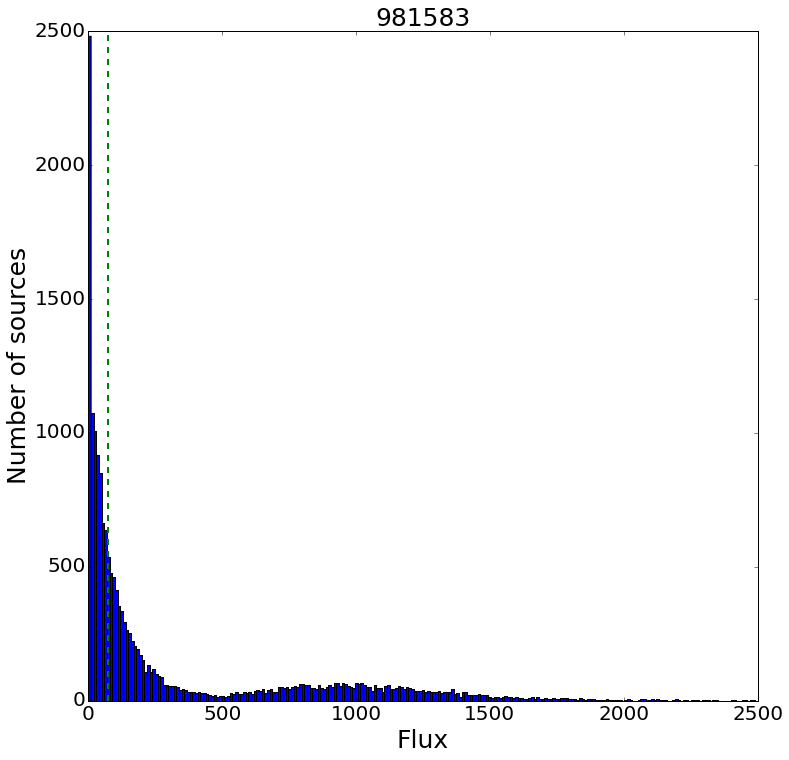

In [10]:
%matplotlib inline
fl, sg = plot_fluxes(diaSourcesList, visit=981583, max_flux=2500, bins = 250)

##Graphical Flux comparison

Obtaining the first available sources with workable coordinates

In [7]:
diaSourcesCatalog = random.choice(diaSourcesList)

for ds in diaSourcesCatalog.get("deepDiff_diaSrc"):
    
    pos= ds.get("ip_diffim_NaiveDipoleCentroid_pos_x")
    if np.isnan(pos) == False:
        break

Creating the stamp on the science exposure

In [32]:
mos = displayUtils.Mosaic()
bbox = ds.getFootprint().getBBox()
Begin = afwGeom.Point2I(bbox.getBeginX(), bbox.getBeginY())
End = afwGeom.Point2I(bbox.getEndX(), bbox.getEndY())
scienceExposure =  diaSourcesCatalog.get("calexp")
ExpOrig = afwGeom.Point2I(scienceExposure.getX0()-1, scienceExposure.getY0()-1)



correctedBegin = bbox.getBegin()- ExpOrig
correctedEnd = bbox.getEnd() - ExpOrig

correctedBegin= afwGeom.Point2I(correctedBegin.getX()-10,correctedBegin.getY()-10 )
correctedEnd = afwGeom.Point2I(correctedEnd.getX()+10,correctedEnd.getY()+10 )
    
    
    
bboxT = afwGeom.Box2I(correctedBegin,correctedEnd)
   
#print bboxT.toString
stamp = scienceExposure.Factory(scienceExposure,bboxT, True)
im = displayUtils.Mosaic(gutter=5, background=5, mode="x")
im.append(stamp.getMaskedImage())
ds9.mtv(stamp, frame=1)

#mos.append(im.makeMosaic())
#mosaicImage = mos.makeMosaic(frame=1, title="mosaic")



Creating the stamp on the template exposure

In [33]:
calexp_template = butler.get("calexp", {"visit":986881, "ccd":14, "filter":"r"})
stamp = calexp_template.Factory(calexp_template,bboxT, True)
#im = displayUtils.Mosaic(gutter=0, background=0, mode="x")
im.append(stamp.getMaskedImage())
ds9.mtv(stamp, frame=2)

Creating the stamp for the subtracted image result

In [34]:

subtractedExposure =  diaSourcesCatalog.get("deepDiff_differenceExp")
stamp = subtractedExposure.Factory(subtractedExposure,bboxT, True)
#im = displayUtils.Mosaic(gutter=0, background=0, mode="x")
im.append(stamp.getMaskedImage())
ds9.mtv(stamp, frame=3)

In [35]:
#ds9.mtv(subtractedExposure, frame=4)
im.makeMosaic(frame=4, title="mosaic")

<lsst.afw.image.imageLib.MaskedImageF; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::image::MaskedImage< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x7f0cc53bad80> >

##Visualization tests

Test methods to paint the sources on the images

In [ ]:
for src1 in diaSrcs1:
    if np.isnan(src1.get("ip_diffim_NaiveDipoleCentroid_pos_x"))==False :
        x = src1.get("ip_diffim_NaiveDipoleCentroid_pos_x")
        y = src1.get("ip_diffim_NaiveDipoleCentroid_pos_y")
        ds9.dot("+", x-cexp.getX0(),y-cexp.getY0(), frame=1, size = 25, ctype = ds9.RED)